In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../Code/')
from testWN import testWN as twm
from surrogate_model_training_data import get_data

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
from surrogate_model_training_data import get_data

# Get network informations

In [4]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Data Pre-Processing

Get clusters:

In [5]:
cluster_label_path = '../clustering/'
cluster_labels = pd.read_json(cluster_label_path+'cluster_labels_only_mpc_02.json')
pressure_factor = pd.read_json(cluster_label_path+'pressure_factor_only_mpc_02.json')
n_clusters = 30

# Create Training Data:

## with random control input:

In [ ]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]
n_arx = 0
nn_input_rc, nn_output_rc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, shift_x=True)
nn_input_rc.shape

Apply filters:

In [6]:
def filter_io(nn_input, nn_output):
    # All filters are formulated, such that they select data to be removed.
    
    f_1 = (nn_output[('aux_outputs','pump_energy')]<=-100).any(axis=1)
    f_2 = (nn_output[('aux_outputs','jun_cl_press_mean')]<=-10).any(axis=1)

    # Maximum junction pressure should not exceed .. :
    jun_cl_press_fac_max = pressure_factor.groupby(cluster_labels.loc['pressure_cluster'], axis=1).max()
    f_3 = ((nn_output[('aux_outputs','jun_cl_press_mean')]*jun_cl_press_fac_max.to_numpy())>=400).any(axis=1)

    # Tank level should not become smaller than 0.2 at next timestep:
    #f_4 = ((nn_input[('sys_states','tank_press')]+nn_output[('sys_states','tank_press')])<=0.01).any(axis=1)
    
    # Tank level should not be at the maximum
    #max_tank_level = np.array([6.75, 6.5, 5, 5.5, 4.5, 5.9, 4.7]).reshape(1,-1)
    #f_5 = ((nn_input[('sys_states','tank_press')]+nn_output[('sys_states','tank_press')])>max_tank_level-0.01).any(axis=1)
    
    min_pump_setting = np.array([0.36, 0.66, 0.66, 0.56, 0.56]).reshape(1,-1)
    f_5 = (nn_input[('sys_inputs','head_pump_speed')]<min_pump_setting).any(axis=1)
    
    f = ~f_1&~f_2&~f_3&~f_5
    return f

In [ ]:
f = filter_io(nn_input_rc, nn_output_rc)
nn_input_rc_filtered = nn_input_rc.loc[f]
nn_output_rc_filtered = nn_output_rc.loc[f]
nn_input_rc_filtered.shape

## without random control input:

In [ ]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_nc, nn_output_nc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, shift_x=True)
nn_input_nc.shape

In [ ]:
# Manually setting the pump setting to the lowest value that results in a shutoff.
min_pump_setting = np.array([0.36, 0.66, 0.66, 0.56, 0.56])
for i,pump_i in enumerate(link_names[0]):
    f1 = (nn_input_nc[('sys_inputs','head_pump_speed',pump_i)]<min_pump_setting[i])
    nn_input_nc[('sys_inputs','head_pump_speed',pump_i)].loc[f1] = min_pump_setting[i]  

In [ ]:
f = filter_io(nn_input_nc, nn_output_nc)
nn_input_nc_filtered = nn_input_nc.loc[f]
nn_output_nc_filtered = nn_output_nc.loc[f]
nn_input_nc_filtered.shape

In [ ]:
n_data_nc = 2000
nn_input_nc_sampled = nn_input_nc_filtered.head(n_data_nc)
nn_output_nc_sampled = nn_output_nc_filtered.head(n_data_nc)
nn_input_nc_sampled.shape

## From previous MPC solutions

In [7]:
data_path_list = ['/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/001_economic/',
            '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/002_tracking/']

file_list = []
for data_path in data_path_list:
    in_dir = os.listdir(data_path)
    file_list.extend([data_path+file_i for file_i in in_dir if '.pkl' in file_i])

n_arx = 0
nn_input_mpc, nn_output_mpc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, shift_x=False)
nn_input_mpc.shape

(10070, 46)

In [8]:
f = filter_io(nn_input_mpc, nn_output_mpc)
nn_input_mpc_filtered = nn_input_mpc.loc[f]
nn_output_mpc_filtered = nn_output_mpc.loc[f]

nn_input_mpc_filtered.shape

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2881: PerformanceWarning:

indexing past lexsort depth may impact performance.



(4887, 46)

In [ ]:
n_aug_mpc = 1
nn_input_mpc_augmented = pd.concat(n_aug_mpc*[nn_input_mpc_filtered])
nn_output_mpc_augmented = pd.concat(n_aug_mpc*[nn_output_mpc_filtered])
nn_input_mpc_augmented.shape

## Concatenate everything:

In [9]:
 #nn_input =  pd.concat((#nn_input_rc_filtered,  
 #                       nn_input_nc_sampled,  
 #                       nn_input_mpc_augmented), axis=0)
 #nn_output = pd.concat((#nn_output_rc_filtered, 
 #                       nn_output_nc_sampled, 
 #                       nn_output_mpc_augmented), axis=0)

nn_input =  nn_input_mpc_filtered
nn_output = nn_output_mpc_filtered

## Manually extend data to balance histogramms on input space

In [ ]:
cond = nn_input[('sys_states','tank_press','T6')]<4.9
nn_input = pd.concat((nn_input, nn_input.loc[cond]))
nn_output = pd.concat((nn_output, nn_output.loc[cond]))

In [ ]:
nn_input.shape

In [ ]:
nn_input[('sys_states','tank_press')].hist()
#nn_input[('sys_inputs','head_pump_speed')].hist()
#nn_input[('sys_inputs','PRValve_dp')].hist()
#nn_input[('sys_inputs','TCValve_throttle')].hist()
#nn_input[('sys_inputs','jun_cl_demand_sum')].hist()


### Normalize Data:

In [10]:
input_offset = 0*nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = 0*nn_output.max()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

In [11]:
output_scaling

sys_states   tank_press         T3        1.774013
                                T1        0.767135
                                T7        2.934528
                                T6        1.510512
                                T5        1.754637
                                T2        1.238836
                                T4        2.719155
aux_outputs  pump_energy        PU2     395.495848
                                PU5     217.083594
                                PU6     355.170424
                                PU8     222.014888
                                PU10    128.847500
             jun_cl_press_mean  0         2.074855
                                1         1.576765
                                2         2.295950
                                3         2.019021
                                4         0.515731
                                5         1.648804
                                6         0.431738
                               

### Train / Test Splitting

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2)

In [13]:
X_train.shape

(3909, 46)

# Neural Network

## Create Model

In [14]:
n_layer = 5
n_units = 50
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nn_input.shape[1]
model_param['n_out'] = nn_output.shape[1]
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 46)]              0         
_________________________________________________________________
dense (Dense)                (None, 50)                2350      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 42)                2142      
Total params: 12,142
Trainable params: 12,142
Non-trainable params: 0
_________________________________________________________

## Train model

In [15]:
optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-8, patience=50, mode='min')
model.compile(optimizer=optim,
              loss='mse')

In [16]:
history = model.fit(X_train.to_numpy(), 
                    Y_train.to_numpy(), 
                    batch_size=500, 
                    epochs=5000,
                    validation_data=(X_test.to_numpy(),Y_test.to_numpy()),)
                    #callbacks=[callback])

Train on 3909 samples, validate on 978 samples
Epoch 1/5000
3909/3909 [==============================] - 1s 301us/sample - loss: 0.1493 - val_loss: 0.0787
Epoch 2/5000
3909/3909 [==============================] - 0s 39us/sample - loss: 0.0517 - val_loss: 0.0303
Epoch 3/5000
3909/3909 [==============================] - 0s 38us/sample - loss: 0.0251 - val_loss: 0.0234
Epoch 4/5000
3909/3909 [==============================] - 0s 41us/sample - loss: 0.0219 - val_loss: 0.0223
Epoch 5/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 0.0197 - val_loss: 0.0196
Epoch 6/5000
3909/3909 [==============================] - 0s 37us/sample - loss: 0.0179 - val_loss: 0.0188
Epoch 7/5000
3909/3909 [==============================] - 0s 32us/sample - loss: 0.0173 - val_loss: 0.0180
Epoch 8/5000
3909/3909 [==============================] - 0s 38us/sample - loss: 0.0165 - val_loss: 0.0173
Epoch 9/5000
3909/3909 [==============================] - 0s 40us/sample - loss: 0.0160 - val_lo

3909/3909 [==============================] - 0s 32us/sample - loss: 0.0034 - val_loss: 0.0038
Epoch 77/5000
3909/3909 [==============================] - 0s 33us/sample - loss: 0.0035 - val_loss: 0.0037
Epoch 78/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 0.0034 - val_loss: 0.0037
Epoch 79/5000
3909/3909 [==============================] - 0s 36us/sample - loss: 0.0034 - val_loss: 0.0036
Epoch 80/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 0.0033 - val_loss: 0.0036
Epoch 81/5000
3909/3909 [==============================] - 0s 28us/sample - loss: 0.0033 - val_loss: 0.0036
Epoch 82/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 0.0033 - val_loss: 0.0035
Epoch 83/5000
3909/3909 [==============================] - 0s 34us/sample - loss: 0.0032 - val_loss: 0.0035
Epoch 84/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 0.0032 - val_loss: 0.0035
Epoch 85/5000
3909/3909 [=================

3909/3909 [==============================] - 0s 28us/sample - loss: 0.0023 - val_loss: 0.0025
Epoch 152/5000
3909/3909 [==============================] - 0s 34us/sample - loss: 0.0023 - val_loss: 0.0025
Epoch 153/5000
3909/3909 [==============================] - 0s 33us/sample - loss: 0.0023 - val_loss: 0.0025
Epoch 154/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 0.0023 - val_loss: 0.0025
Epoch 155/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 0.0023 - val_loss: 0.0025
Epoch 156/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 0.0023 - val_loss: 0.0025
Epoch 157/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 0.0022 - val_loss: 0.0025
Epoch 158/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 0.0023 - val_loss: 0.0025
Epoch 159/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 0.0022 - val_loss: 0.0025
Epoch 160/5000
3909/3909 [========

3909/3909 [==============================] - 0s 20us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 227/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 0.0018 - val_loss: 0.0021
Epoch 228/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 0.0018 - val_loss: 0.0021
Epoch 229/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 0.0019 - val_loss: 0.0021
Epoch 230/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 231/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 0.0018 - val_loss: 0.0020
Epoch 232/5000
3909/3909 [==============================] - 0s 19us/sample - loss: 0.0018 - val_loss: 0.0020
Epoch 233/5000
3909/3909 [==============================] - 0s 19us/sample - loss: 0.0018 - val_loss: 0.0020
Epoch 234/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 0.0018 - val_loss: 0.0020
Epoch 235/5000
3909/3909 [========

3909/3909 [==============================] - 0s 20us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 302/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 303/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 304/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 305/5000
3909/3909 [==============================] - 0s 24us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 306/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 307/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 308/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 309/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 310/5000
3909/3909 [========

3909/3909 [==============================] - 0s 23us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 377/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 378/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 379/5000
3909/3909 [==============================] - 0s 19us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 380/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 381/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 382/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 383/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 384/5000
3909/3909 [==============================] - 0s 25us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 385/5000
3909/3909 [========

3909/3909 [==============================] - 0s 20us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 452/5000
3909/3909 [==============================] - 0s 25us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 453/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 454/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 455/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 456/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 457/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 458/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 459/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 460/5000
3909/3909 [========

3909/3909 [==============================] - 0s 28us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 527/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 528/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 529/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 530/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 531/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 532/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 533/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 534/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 535/5000
3909/3909 [========

3909/3909 [==============================] - 0s 21us/sample - loss: 0.0010 - val_loss: 0.0012
Epoch 602/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 0.0010 - val_loss: 0.0012
Epoch 603/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 9.9203e-04 - val_loss: 0.0011
Epoch 604/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 9.8979e-04 - val_loss: 0.0012
Epoch 605/5000
3909/3909 [==============================] - 0s 19us/sample - loss: 0.0010 - val_loss: 0.0012
Epoch 606/5000
3909/3909 [==============================] - 0s 19us/sample - loss: 9.9802e-04 - val_loss: 0.0012
Epoch 607/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 0.0010 - val_loss: 0.0012
Epoch 608/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 9.9180e-04 - val_loss: 0.0011
Epoch 609/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 9.8600e-04 - val_loss: 0.0012
Epoch 610/5000

Epoch 674/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 9.4405e-04 - val_loss: 0.0011
Epoch 675/5000
3909/3909 [==============================] - 0s 24us/sample - loss: 9.0956e-04 - val_loss: 0.0011
Epoch 676/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 9.0154e-04 - val_loss: 0.0011
Epoch 677/5000
3909/3909 [==============================] - 0s 28us/sample - loss: 9.1906e-04 - val_loss: 0.0011
Epoch 678/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 9.4115e-04 - val_loss: 0.0011
Epoch 679/5000
3909/3909 [==============================] - 0s 33us/sample - loss: 9.5582e-04 - val_loss: 0.0012
Epoch 680/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 9.5523e-04 - val_loss: 0.0011
Epoch 681/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 9.3443e-04 - val_loss: 0.0011
Epoch 682/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 9.1003e-04 - 

3909/3909 [==============================] - 0s 29us/sample - loss: 8.5751e-04 - val_loss: 0.0010
Epoch 747/5000
3909/3909 [==============================] - 0s 32us/sample - loss: 8.3118e-04 - val_loss: 0.0010
Epoch 748/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 8.3801e-04 - val_loss: 0.0010
Epoch 749/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 8.4414e-04 - val_loss: 0.0010
Epoch 750/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 8.4252e-04 - val_loss: 9.9857e-04
Epoch 751/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 8.5051e-04 - val_loss: 0.0010
Epoch 752/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 8.6282e-04 - val_loss: 0.0010
Epoch 753/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 8.5013e-04 - val_loss: 0.0010
Epoch 754/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 8.5048e-04 - val_loss: 0

3909/3909 [==============================] - 0s 22us/sample - loss: 7.7831e-04 - val_loss: 9.8349e-04
Epoch 818/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 7.8507e-04 - val_loss: 9.5322e-04
Epoch 819/5000
3909/3909 [==============================] - 0s 19us/sample - loss: 7.7368e-04 - val_loss: 9.4338e-04
Epoch 820/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 7.7414e-04 - val_loss: 9.4722e-04
Epoch 821/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 7.8242e-04 - val_loss: 9.4053e-04
Epoch 822/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 7.7214e-04 - val_loss: 9.4705e-04
Epoch 823/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 7.7447e-04 - val_loss: 9.5816e-04
Epoch 824/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 7.7932e-04 - val_loss: 9.7190e-04
Epoch 825/5000
3909/3909 [==============================] - 0s 32us/sample - lo

3909/3909 [==============================] - 0s 29us/sample - loss: 7.4353e-04 - val_loss: 9.3605e-04
Epoch 888/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 7.4761e-04 - val_loss: 9.4077e-04
Epoch 889/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 7.5213e-04 - val_loss: 9.0461e-04
Epoch 890/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 7.5349e-04 - val_loss: 9.1896e-04
Epoch 891/5000
3909/3909 [==============================] - 0s 32us/sample - loss: 7.4038e-04 - val_loss: 9.5937e-04
Epoch 892/5000
3909/3909 [==============================] - 0s 32us/sample - loss: 7.5800e-04 - val_loss: 9.6326e-04
Epoch 893/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 7.5014e-04 - val_loss: 9.7178e-04
Epoch 894/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 7.5584e-04 - val_loss: 9.1557e-04
Epoch 895/5000
3909/3909 [==============================] - 0s 28us/sample - lo

3909/3909 [==============================] - 0s 21us/sample - loss: 6.7703e-04 - val_loss: 8.6601e-04
Epoch 958/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 6.7614e-04 - val_loss: 8.7424e-04
Epoch 959/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 6.9712e-04 - val_loss: 9.1044e-04
Epoch 960/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 6.9990e-04 - val_loss: 8.8741e-04
Epoch 961/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 6.8179e-04 - val_loss: 8.6969e-04
Epoch 962/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 6.7790e-04 - val_loss: 8.5524e-04
Epoch 963/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 6.7038e-04 - val_loss: 8.5953e-04
Epoch 964/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 6.7075e-04 - val_loss: 8.6742e-04
Epoch 965/5000
3909/3909 [==============================] - 0s 21us/sample - lo

Epoch 1027/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 6.4835e-04 - val_loss: 8.5333e-04
Epoch 1028/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 6.4285e-04 - val_loss: 8.3536e-04
Epoch 1029/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 6.4988e-04 - val_loss: 8.8217e-04
Epoch 1030/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 6.6093e-04 - val_loss: 8.5011e-04
Epoch 1031/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 6.6238e-04 - val_loss: 8.2909e-04
Epoch 1032/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 6.5511e-04 - val_loss: 8.6299e-04
Epoch 1033/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 6.4520e-04 - val_loss: 8.4226e-04
Epoch 1034/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 6.3020e-04 - val_loss: 8.2096e-04
Epoch 1035/5000
3909/3909 [=============================

3909/3909 [==============================] - 0s 21us/sample - loss: 6.2708e-04 - val_loss: 8.0643e-04
Epoch 1097/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 6.1707e-04 - val_loss: 8.1242e-04
Epoch 1098/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 6.1294e-04 - val_loss: 8.4350e-04
Epoch 1099/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 6.3261e-04 - val_loss: 8.2589e-04
Epoch 1100/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 6.3095e-04 - val_loss: 8.3939e-04
Epoch 1101/5000
3909/3909 [==============================] - 0s 27us/sample - loss: 6.2490e-04 - val_loss: 8.0521e-04
Epoch 1102/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 6.0530e-04 - val_loss: 8.4443e-04
Epoch 1103/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 6.3499e-04 - val_loss: 8.0884e-04
Epoch 1104/5000
3909/3909 [==============================] - 0s 22us/sam

3909/3909 [==============================] - 0s 21us/sample - loss: 5.9400e-04 - val_loss: 7.7412e-04
Epoch 1166/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 5.8280e-04 - val_loss: 7.7420e-04
Epoch 1167/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 5.6799e-04 - val_loss: 7.8068e-04
Epoch 1168/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 5.7459e-04 - val_loss: 7.6725e-04
Epoch 1169/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 5.7998e-04 - val_loss: 7.7971e-04
Epoch 1170/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 5.7781e-04 - val_loss: 7.6854e-04
Epoch 1171/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 5.7072e-04 - val_loss: 7.8057e-04
Epoch 1172/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 5.8187e-04 - val_loss: 8.0462e-04
Epoch 1173/5000
3909/3909 [==============================] - 0s 20us/sam

3909/3909 [==============================] - 0s 29us/sample - loss: 5.8060e-04 - val_loss: 7.6567e-04
Epoch 1235/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 5.6920e-04 - val_loss: 7.5537e-04
Epoch 1236/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 5.6348e-04 - val_loss: 7.8273e-04
Epoch 1237/5000
3909/3909 [==============================] - 0s 27us/sample - loss: 5.6964e-04 - val_loss: 7.6540e-04
Epoch 1238/5000
3909/3909 [==============================] - 0s 28us/sample - loss: 5.5601e-04 - val_loss: 7.4952e-04
Epoch 1239/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 5.7393e-04 - val_loss: 8.3138e-04
Epoch 1240/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 5.7260e-04 - val_loss: 7.8262e-04
Epoch 1241/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 5.6630e-04 - val_loss: 7.6250e-04
Epoch 1242/5000
3909/3909 [==============================] - 0s 29us/sam

3909/3909 [==============================] - 0s 29us/sample - loss: 5.4844e-04 - val_loss: 7.8714e-04
Epoch 1304/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 5.6421e-04 - val_loss: 7.5333e-04
Epoch 1305/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 5.4147e-04 - val_loss: 7.3664e-04
Epoch 1306/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 5.3152e-04 - val_loss: 7.3298e-04
Epoch 1307/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 5.3588e-04 - val_loss: 7.3835e-04
Epoch 1308/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 5.3985e-04 - val_loss: 7.3813e-04
Epoch 1309/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 5.4642e-04 - val_loss: 7.5012e-04
Epoch 1310/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 5.5052e-04 - val_loss: 7.3157e-04
Epoch 1311/5000
3909/3909 [==============================] - 0s 30us/sam

3909/3909 [==============================] - 0s 29us/sample - loss: 5.2353e-04 - val_loss: 7.2507e-04
Epoch 1373/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 5.3647e-04 - val_loss: 7.4022e-04
Epoch 1374/5000
3909/3909 [==============================] - 0s 33us/sample - loss: 5.4949e-04 - val_loss: 7.3938e-04
Epoch 1375/5000
3909/3909 [==============================] - 0s 37us/sample - loss: 5.3261e-04 - val_loss: 7.3114e-04
Epoch 1376/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 5.2686e-04 - val_loss: 7.3792e-04
Epoch 1377/5000
3909/3909 [==============================] - 0s 35us/sample - loss: 5.2867e-04 - val_loss: 7.4378e-04
Epoch 1378/5000
3909/3909 [==============================] - 0s 32us/sample - loss: 5.2642e-04 - val_loss: 7.3377e-04
Epoch 1379/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 5.3039e-04 - val_loss: 7.3141e-04
Epoch 1380/5000
3909/3909 [==============================] - 0s 30us/sam

3909/3909 [==============================] - 0s 20us/sample - loss: 5.2707e-04 - val_loss: 7.6717e-04
Epoch 1442/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 5.2117e-04 - val_loss: 7.1055e-04
Epoch 1443/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 4.9528e-04 - val_loss: 7.0867e-04
Epoch 1444/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 5.0009e-04 - val_loss: 6.8904e-04
Epoch 1445/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 4.9087e-04 - val_loss: 6.8974e-04
Epoch 1446/5000
3909/3909 [==============================] - 0s 19us/sample - loss: 4.9748e-04 - val_loss: 7.0247e-04
Epoch 1447/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 4.9269e-04 - val_loss: 7.0851e-04
Epoch 1448/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 5.0186e-04 - val_loss: 6.9052e-04
Epoch 1449/5000
3909/3909 [==============================] - 0s 22us/sam

3909/3909 [==============================] - 0s 20us/sample - loss: 5.0163e-04 - val_loss: 7.4719e-04
Epoch 1511/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 4.9795e-04 - val_loss: 7.0970e-04
Epoch 1512/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 4.8341e-04 - val_loss: 7.0400e-04
Epoch 1513/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 4.9047e-04 - val_loss: 6.8796e-04
Epoch 1514/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 4.8630e-04 - val_loss: 6.9996e-04
Epoch 1515/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 4.8467e-04 - val_loss: 6.7965e-04
Epoch 1516/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 4.7278e-04 - val_loss: 6.7759e-04
Epoch 1517/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 4.7477e-04 - val_loss: 6.8810e-04
Epoch 1518/5000
3909/3909 [==============================] - 0s 21us/sam

3909/3909 [==============================] - 0s 31us/sample - loss: 4.8494e-04 - val_loss: 6.6290e-04
Epoch 1580/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 4.8686e-04 - val_loss: 7.0736e-04
Epoch 1581/5000
3909/3909 [==============================] - 0s 32us/sample - loss: 4.8384e-04 - val_loss: 6.8366e-04
Epoch 1582/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 4.8456e-04 - val_loss: 7.1257e-04
Epoch 1583/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 4.8866e-04 - val_loss: 7.0035e-04
Epoch 1584/5000
3909/3909 [==============================] - 0s 28us/sample - loss: 4.7852e-04 - val_loss: 6.9228e-04
Epoch 1585/5000
3909/3909 [==============================] - 0s 32us/sample - loss: 4.8117e-04 - val_loss: 6.9388e-04
Epoch 1586/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 4.8972e-04 - val_loss: 6.7710e-04
Epoch 1587/5000
3909/3909 [==============================] - 0s 37us/sam

3909/3909 [==============================] - 0s 21us/sample - loss: 4.7253e-04 - val_loss: 6.9574e-04
Epoch 1649/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 4.6615e-04 - val_loss: 6.7978e-04
Epoch 1650/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 4.6177e-04 - val_loss: 6.6959e-04
Epoch 1651/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 4.6530e-04 - val_loss: 6.7445e-04
Epoch 1652/5000
3909/3909 [==============================] - 0s 25us/sample - loss: 4.6412e-04 - val_loss: 6.6422e-04
Epoch 1653/5000
3909/3909 [==============================] - 0s 28us/sample - loss: 4.5147e-04 - val_loss: 6.6027e-04
Epoch 1654/5000
3909/3909 [==============================] - 0s 28us/sample - loss: 4.4559e-04 - val_loss: 6.8133e-04
Epoch 1655/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 4.6098e-04 - val_loss: 6.7839e-04
Epoch 1656/5000
3909/3909 [==============================] - 0s 29us/sam

3909/3909 [==============================] - 0s 21us/sample - loss: 4.4453e-04 - val_loss: 6.5756e-04
Epoch 1718/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 4.5077e-04 - val_loss: 6.5782e-04
Epoch 1719/5000
3909/3909 [==============================] - 0s 27us/sample - loss: 4.5324e-04 - val_loss: 6.5128e-04
Epoch 1720/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 4.4701e-04 - val_loss: 6.7071e-04
Epoch 1721/5000
3909/3909 [==============================] - 0s 32us/sample - loss: 4.4862e-04 - val_loss: 6.5946e-04
Epoch 1722/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 4.4896e-04 - val_loss: 6.7871e-04
Epoch 1723/5000
3909/3909 [==============================] - 0s 32us/sample - loss: 4.4726e-04 - val_loss: 6.5874e-04
Epoch 1724/5000
3909/3909 [==============================] - 0s 35us/sample - loss: 4.6299e-04 - val_loss: 7.5253e-04
Epoch 1725/5000
3909/3909 [==============================] - 0s 36us/sam

3909/3909 [==============================] - 0s 21us/sample - loss: 4.5808e-04 - val_loss: 6.7846e-04
Epoch 1787/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 4.4908e-04 - val_loss: 6.3732e-04
Epoch 1788/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 4.2883e-04 - val_loss: 6.4545e-04
Epoch 1789/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 4.3703e-04 - val_loss: 6.3118e-04
Epoch 1790/5000
3909/3909 [==============================] - 0s 34us/sample - loss: 4.3469e-04 - val_loss: 6.7028e-04
Epoch 1791/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 4.6174e-04 - val_loss: 6.4895e-04
Epoch 1792/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 4.4528e-04 - val_loss: 6.5773e-04
Epoch 1793/5000
3909/3909 [==============================] - 0s 28us/sample - loss: 4.5105e-04 - val_loss: 6.7372e-04
Epoch 1794/5000
3909/3909 [==============================] - 0s 33us/sam

3909/3909 [==============================] - 0s 25us/sample - loss: 4.2256e-04 - val_loss: 6.5061e-04
Epoch 1856/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 4.2443e-04 - val_loss: 6.2473e-04
Epoch 1857/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 4.1710e-04 - val_loss: 6.2859e-04
Epoch 1858/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 4.2535e-04 - val_loss: 6.2680e-04
Epoch 1859/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 4.2329e-04 - val_loss: 6.1663e-04
Epoch 1860/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 4.2527e-04 - val_loss: 6.3745e-04
Epoch 1861/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 4.3601e-04 - val_loss: 6.2593e-04
Epoch 1862/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 4.2635e-04 - val_loss: 6.4199e-04
Epoch 1863/5000
3909/3909 [==============================] - 0s 21us/sam

3909/3909 [==============================] - 0s 22us/sample - loss: 4.1409e-04 - val_loss: 6.2451e-04
Epoch 1925/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 4.1058e-04 - val_loss: 6.1523e-04
Epoch 1926/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 4.0803e-04 - val_loss: 6.1372e-04
Epoch 1927/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 4.0624e-04 - val_loss: 6.2000e-04
Epoch 1928/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 4.0894e-04 - val_loss: 6.1622e-04
Epoch 1929/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 4.0685e-04 - val_loss: 6.1976e-04
Epoch 1930/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 4.1645e-04 - val_loss: 6.3041e-04
Epoch 1931/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 4.1899e-04 - val_loss: 6.3599e-04
Epoch 1932/5000
3909/3909 [==============================] - 0s 21us/sam

3909/3909 [==============================] - 0s 31us/sample - loss: 3.9614e-04 - val_loss: 6.0927e-04
Epoch 1994/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 3.9984e-04 - val_loss: 6.0591e-04
Epoch 1995/5000
3909/3909 [==============================] - 0s 38us/sample - loss: 3.9625e-04 - val_loss: 6.0899e-04
Epoch 1996/5000
3909/3909 [==============================] - 0s 37us/sample - loss: 3.9538e-04 - val_loss: 5.9487e-04
Epoch 1997/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 3.9502e-04 - val_loss: 5.9451e-04
Epoch 1998/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 4.0784e-04 - val_loss: 5.9515e-04
Epoch 1999/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 4.0438e-04 - val_loss: 6.1539e-04
Epoch 2000/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 4.0964e-04 - val_loss: 6.0209e-04
Epoch 2001/5000
3909/3909 [==============================] - 0s 28us/sam

3909/3909 [==============================] - 0s 20us/sample - loss: 3.9818e-04 - val_loss: 6.0262e-04
Epoch 2063/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 3.9232e-04 - val_loss: 5.9698e-04
Epoch 2064/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.8962e-04 - val_loss: 5.9495e-04
Epoch 2065/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 3.8291e-04 - val_loss: 5.8389e-04
Epoch 2066/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 3.8603e-04 - val_loss: 5.9407e-04
Epoch 2067/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.9237e-04 - val_loss: 5.8925e-04
Epoch 2068/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 3.8586e-04 - val_loss: 5.8907e-04
Epoch 2069/5000
3909/3909 [==============================] - 0s 24us/sample - loss: 3.9386e-04 - val_loss: 6.3117e-04
Epoch 2070/5000
3909/3909 [==============================] - 0s 22us/sam

3909/3909 [==============================] - 0s 29us/sample - loss: 4.0575e-04 - val_loss: 5.9081e-04
Epoch 2132/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 3.9676e-04 - val_loss: 6.0125e-04
Epoch 2133/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 4.0334e-04 - val_loss: 6.2519e-04
Epoch 2134/5000
3909/3909 [==============================] - 0s 26us/sample - loss: 3.9226e-04 - val_loss: 5.7512e-04
Epoch 2135/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.7723e-04 - val_loss: 5.7825e-04
Epoch 2136/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 3.7946e-04 - val_loss: 5.8784e-04
Epoch 2137/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 3.9057e-04 - val_loss: 6.3151e-04
Epoch 2138/5000
3909/3909 [==============================] - 0s 25us/sample - loss: 3.8983e-04 - val_loss: 6.0803e-04
Epoch 2139/5000
3909/3909 [==============================] - 0s 20us/sam

3909/3909 [==============================] - 0s 21us/sample - loss: 3.7948e-04 - val_loss: 5.7904e-04
Epoch 2201/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 3.7994e-04 - val_loss: 5.7457e-04
Epoch 2202/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.7052e-04 - val_loss: 5.7911e-04
Epoch 2203/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.6754e-04 - val_loss: 5.6965e-04
Epoch 2204/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 3.6319e-04 - val_loss: 5.6920e-04
Epoch 2205/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 3.7285e-04 - val_loss: 5.8601e-04
Epoch 2206/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 3.7232e-04 - val_loss: 5.8553e-04
Epoch 2207/5000
3909/3909 [==============================] - 0s 19us/sample - loss: 3.7939e-04 - val_loss: 5.8912e-04
Epoch 2208/5000
3909/3909 [==============================] - 0s 20us/sam

3909/3909 [==============================] - 0s 36us/sample - loss: 3.8230e-04 - val_loss: 5.7702e-04
Epoch 2270/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 3.7646e-04 - val_loss: 5.8775e-04
Epoch 2271/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 3.7110e-04 - val_loss: 5.7556e-04
Epoch 2272/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.7248e-04 - val_loss: 5.7012e-04
Epoch 2273/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 3.7196e-04 - val_loss: 6.0225e-04
Epoch 2274/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 3.9061e-04 - val_loss: 6.0595e-04
Epoch 2275/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 3.8584e-04 - val_loss: 5.7832e-04
Epoch 2276/5000
3909/3909 [==============================] - 0s 36us/sample - loss: 3.6505e-04 - val_loss: 5.7462e-04
Epoch 2277/5000
3909/3909 [==============================] - 0s 29us/sam

3909/3909 [==============================] - 0s 28us/sample - loss: 3.6067e-04 - val_loss: 5.5597e-04
Epoch 2339/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 3.5933e-04 - val_loss: 5.6473e-04
Epoch 2340/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 3.7946e-04 - val_loss: 5.5652e-04
Epoch 2341/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 3.7919e-04 - val_loss: 5.6879e-04
Epoch 2342/5000
3909/3909 [==============================] - 0s 33us/sample - loss: 3.6272e-04 - val_loss: 5.6924e-04
Epoch 2343/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 3.6633e-04 - val_loss: 5.7429e-04
Epoch 2344/5000
3909/3909 [==============================] - 0s 36us/sample - loss: 3.7407e-04 - val_loss: 5.8064e-04
Epoch 2345/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 3.7632e-04 - val_loss: 5.8187e-04
Epoch 2346/5000
3909/3909 [==============================] - 0s 30us/sam

3909/3909 [==============================] - 0s 43us/sample - loss: 3.7608e-04 - val_loss: 5.8296e-04
Epoch 2408/5000
3909/3909 [==============================] - 0s 34us/sample - loss: 3.5234e-04 - val_loss: 5.6292e-04
Epoch 2409/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 3.5231e-04 - val_loss: 5.5245e-04
Epoch 2410/5000
3909/3909 [==============================] - 0s 37us/sample - loss: 3.5034e-04 - val_loss: 6.1882e-04
Epoch 2411/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 3.6602e-04 - val_loss: 5.5750e-04
Epoch 2412/5000
3909/3909 [==============================] - 0s 34us/sample - loss: 3.5733e-04 - val_loss: 5.6163e-04
Epoch 2413/5000
3909/3909 [==============================] - 0s 43us/sample - loss: 3.6284e-04 - val_loss: 5.4741e-04
Epoch 2414/5000
3909/3909 [==============================] - 0s 37us/sample - loss: 3.5122e-04 - val_loss: 5.4503e-04
Epoch 2415/5000
3909/3909 [==============================] - 0s 31us/sam

3909/3909 [==============================] - 0s 28us/sample - loss: 3.5305e-04 - val_loss: 5.6305e-04
Epoch 2477/5000
3909/3909 [==============================] - 0s 25us/sample - loss: 3.5298e-04 - val_loss: 5.6333e-04
Epoch 2478/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 3.5036e-04 - val_loss: 5.6058e-04
Epoch 2479/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.5029e-04 - val_loss: 5.4029e-04
Epoch 2480/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 3.6006e-04 - val_loss: 5.8421e-04
Epoch 2481/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 3.7737e-04 - val_loss: 5.5860e-04
Epoch 2482/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.6582e-04 - val_loss: 5.5418e-04
Epoch 2483/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 3.4582e-04 - val_loss: 5.6845e-04
Epoch 2484/5000
3909/3909 [==============================] - 0s 20us/sam

3909/3909 [==============================] - 0s 23us/sample - loss: 3.4614e-04 - val_loss: 5.5609e-04
Epoch 2546/5000
3909/3909 [==============================] - 0s 26us/sample - loss: 3.8670e-04 - val_loss: 5.8125e-04
Epoch 2547/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 3.6073e-04 - val_loss: 5.5294e-04
Epoch 2548/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.4838e-04 - val_loss: 5.3939e-04
Epoch 2549/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.4127e-04 - val_loss: 5.2883e-04
Epoch 2550/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 3.4762e-04 - val_loss: 5.5764e-04
Epoch 2551/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.5048e-04 - val_loss: 5.7997e-04
Epoch 2552/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 3.4127e-04 - val_loss: 5.3848e-04
Epoch 2553/5000
3909/3909 [==============================] - 0s 20us/sam

3909/3909 [==============================] - 0s 20us/sample - loss: 3.4441e-04 - val_loss: 5.5378e-04
Epoch 2615/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 3.3361e-04 - val_loss: 5.2344e-04
Epoch 2616/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 3.4102e-04 - val_loss: 5.4525e-04
Epoch 2617/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 3.3026e-04 - val_loss: 5.2231e-04
Epoch 2618/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 3.2486e-04 - val_loss: 5.2770e-04
Epoch 2619/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.2939e-04 - val_loss: 5.3309e-04
Epoch 2620/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.4530e-04 - val_loss: 5.5514e-04
Epoch 2621/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 3.4164e-04 - val_loss: 5.3961e-04
Epoch 2622/5000
3909/3909 [==============================] - 0s 20us/sam

3909/3909 [==============================] - 0s 22us/sample - loss: 3.3251e-04 - val_loss: 5.4263e-04
Epoch 2684/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 3.2836e-04 - val_loss: 5.1804e-04
Epoch 2685/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.2706e-04 - val_loss: 5.1326e-04
Epoch 2686/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 3.2444e-04 - val_loss: 5.2316e-04
Epoch 2687/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 3.2562e-04 - val_loss: 5.3235e-04
Epoch 2688/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 3.3705e-04 - val_loss: 5.4694e-04
Epoch 2689/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.4037e-04 - val_loss: 5.9250e-04
Epoch 2690/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.5100e-04 - val_loss: 5.4383e-04
Epoch 2691/5000
3909/3909 [==============================] - 0s 20us/sam

3909/3909 [==============================] - 0s 21us/sample - loss: 3.0843e-04 - val_loss: 5.0970e-04
Epoch 2753/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 3.1781e-04 - val_loss: 5.1701e-04
Epoch 2754/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.4000e-04 - val_loss: 5.2274e-04
Epoch 2755/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.3270e-04 - val_loss: 5.3520e-04
Epoch 2756/5000
3909/3909 [==============================] - 0s 24us/sample - loss: 3.2589e-04 - val_loss: 5.2061e-04
Epoch 2757/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 3.2259e-04 - val_loss: 5.1526e-04
Epoch 2758/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 3.3122e-04 - val_loss: 5.4023e-04
Epoch 2759/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.3887e-04 - val_loss: 5.4949e-04
Epoch 2760/5000
3909/3909 [==============================] - 0s 20us/sam

3909/3909 [==============================] - 0s 33us/sample - loss: 3.3702e-04 - val_loss: 5.5826e-04
Epoch 2822/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 3.3289e-04 - val_loss: 5.7009e-04
Epoch 2823/5000
3909/3909 [==============================] - 0s 35us/sample - loss: 3.3980e-04 - val_loss: 5.1268e-04
Epoch 2824/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 3.2334e-04 - val_loss: 5.1117e-04
Epoch 2825/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 3.1748e-04 - val_loss: 5.0665e-04
Epoch 2826/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.1739e-04 - val_loss: 5.2632e-04
Epoch 2827/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 3.2520e-04 - val_loss: 5.3050e-04
Epoch 2828/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.1558e-04 - val_loss: 5.3019e-04
Epoch 2829/5000
3909/3909 [==============================] - 0s 22us/sam

3909/3909 [==============================] - 0s 30us/sample - loss: 3.1546e-04 - val_loss: 5.0590e-04
Epoch 2891/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 3.0986e-04 - val_loss: 5.0068e-04
Epoch 2892/5000
3909/3909 [==============================] - 0s 39us/sample - loss: 3.0308e-04 - val_loss: 5.0167e-04
Epoch 2893/5000
3909/3909 [==============================] - 0s 32us/sample - loss: 3.0580e-04 - val_loss: 5.1332e-04
Epoch 2894/5000
3909/3909 [==============================] - 0s 36us/sample - loss: 3.1237e-04 - val_loss: 5.2131e-04
Epoch 2895/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 3.1180e-04 - val_loss: 5.0196e-04
Epoch 2896/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 2.9956e-04 - val_loss: 5.0932e-04
Epoch 2897/5000
3909/3909 [==============================] - 0s 28us/sample - loss: 3.1563e-04 - val_loss: 4.9952e-04
Epoch 2898/5000
3909/3909 [==============================] - 0s 32us/sam

3909/3909 [==============================] - 0s 32us/sample - loss: 2.9676e-04 - val_loss: 4.9651e-04
Epoch 2960/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 2.9863e-04 - val_loss: 5.1122e-04
Epoch 2961/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 3.1354e-04 - val_loss: 5.1013e-04
Epoch 2962/5000
3909/3909 [==============================] - 0s 40us/sample - loss: 3.1547e-04 - val_loss: 4.9290e-04
Epoch 2963/5000
3909/3909 [==============================] - 0s 33us/sample - loss: 3.3191e-04 - val_loss: 5.5599e-04
Epoch 2964/5000
3909/3909 [==============================] - 0s 36us/sample - loss: 3.2830e-04 - val_loss: 4.9974e-04
Epoch 2965/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 3.1633e-04 - val_loss: 5.5102e-04
Epoch 2966/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 3.2788e-04 - val_loss: 5.4482e-04
Epoch 2967/5000
3909/3909 [==============================] - 0s 30us/sam

3909/3909 [==============================] - 0s 20us/sample - loss: 3.1099e-04 - val_loss: 5.0233e-04
Epoch 3029/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 3.0789e-04 - val_loss: 5.0570e-04
Epoch 3030/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 3.0773e-04 - val_loss: 5.0867e-04
Epoch 3031/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.0635e-04 - val_loss: 4.9791e-04
Epoch 3032/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 3.0306e-04 - val_loss: 5.0408e-04
Epoch 3033/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.9591e-04 - val_loss: 4.9892e-04
Epoch 3034/5000
3909/3909 [==============================] - 0s 24us/sample - loss: 2.9340e-04 - val_loss: 4.9184e-04
Epoch 3035/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.1214e-04 - val_loss: 5.1866e-04
Epoch 3036/5000
3909/3909 [==============================] - 0s 20us/sam

3909/3909 [==============================] - 0s 20us/sample - loss: 3.0595e-04 - val_loss: 5.1769e-04
Epoch 3098/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.1442e-04 - val_loss: 5.0790e-04
Epoch 3099/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 2.9813e-04 - val_loss: 4.9117e-04
Epoch 3100/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.9593e-04 - val_loss: 5.0313e-04
Epoch 3101/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 3.0350e-04 - val_loss: 4.8889e-04
Epoch 3102/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.9834e-04 - val_loss: 5.0298e-04
Epoch 3103/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 2.8707e-04 - val_loss: 4.8336e-04
Epoch 3104/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 2.8757e-04 - val_loss: 4.9033e-04
Epoch 3105/5000
3909/3909 [==============================] - 0s 22us/sam

3909/3909 [==============================] - 0s 21us/sample - loss: 2.8565e-04 - val_loss: 4.8527e-04
Epoch 3167/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 2.8856e-04 - val_loss: 4.8714e-04
Epoch 3168/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 2.9332e-04 - val_loss: 4.9599e-04
Epoch 3169/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 2.9184e-04 - val_loss: 4.8954e-04
Epoch 3170/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.9660e-04 - val_loss: 4.8783e-04
Epoch 3171/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 2.8668e-04 - val_loss: 5.1021e-04
Epoch 3172/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.9173e-04 - val_loss: 4.9233e-04
Epoch 3173/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 2.8784e-04 - val_loss: 4.9213e-04
Epoch 3174/5000
3909/3909 [==============================] - 0s 20us/sam

3909/3909 [==============================] - 0s 32us/sample - loss: 2.9036e-04 - val_loss: 4.7233e-04
Epoch 3236/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 2.7318e-04 - val_loss: 4.8116e-04
Epoch 3237/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 2.7812e-04 - val_loss: 4.8864e-04
Epoch 3238/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.8767e-04 - val_loss: 5.1272e-04
Epoch 3239/5000
3909/3909 [==============================] - 0s 24us/sample - loss: 3.0066e-04 - val_loss: 4.9511e-04
Epoch 3240/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.8377e-04 - val_loss: 4.6889e-04
Epoch 3241/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.7419e-04 - val_loss: 5.0628e-04
Epoch 3242/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 2.9199e-04 - val_loss: 4.9709e-04
Epoch 3243/5000
3909/3909 [==============================] - 0s 20us/sam

3909/3909 [==============================] - 0s 30us/sample - loss: 2.8292e-04 - val_loss: 4.8345e-04
Epoch 3305/5000
3909/3909 [==============================] - 0s 33us/sample - loss: 2.8474e-04 - val_loss: 4.8005e-04
Epoch 3306/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 2.7681e-04 - val_loss: 4.7510e-04
Epoch 3307/5000
3909/3909 [==============================] - 0s 45us/sample - loss: 2.7324e-04 - val_loss: 4.9293e-04
Epoch 3308/5000
3909/3909 [==============================] - 0s 35us/sample - loss: 2.8380e-04 - val_loss: 4.8873e-04
Epoch 3309/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 2.9022e-04 - val_loss: 4.8264e-04
Epoch 3310/5000
3909/3909 [==============================] - 0s 32us/sample - loss: 2.9222e-04 - val_loss: 5.0540e-04
Epoch 3311/5000
3909/3909 [==============================] - 0s 32us/sample - loss: 2.8578e-04 - val_loss: 4.8968e-04
Epoch 3312/5000
3909/3909 [==============================] - 0s 30us/sam

3909/3909 [==============================] - 0s 24us/sample - loss: 2.7300e-04 - val_loss: 4.7867e-04
Epoch 3374/5000
3909/3909 [==============================] - 0s 28us/sample - loss: 2.6699e-04 - val_loss: 4.8511e-04
Epoch 3375/5000
3909/3909 [==============================] - 0s 28us/sample - loss: 2.6916e-04 - val_loss: 4.6811e-04
Epoch 3376/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 2.6942e-04 - val_loss: 4.7459e-04
Epoch 3377/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 2.6779e-04 - val_loss: 4.7307e-04
Epoch 3378/5000
3909/3909 [==============================] - 0s 28us/sample - loss: 2.7605e-04 - val_loss: 5.0014e-04
Epoch 3379/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 2.9272e-04 - val_loss: 4.9463e-04
Epoch 3380/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 2.8478e-04 - val_loss: 4.9219e-04
Epoch 3381/5000
3909/3909 [==============================] - 0s 32us/sam

3909/3909 [==============================] - 0s 21us/sample - loss: 2.6694e-04 - val_loss: 4.7579e-04
Epoch 3443/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.6976e-04 - val_loss: 4.8299e-04
Epoch 3444/5000
3909/3909 [==============================] - 0s 19us/sample - loss: 2.7441e-04 - val_loss: 4.7529e-04
Epoch 3445/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 2.8274e-04 - val_loss: 4.8207e-04
Epoch 3446/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 2.9445e-04 - val_loss: 5.2943e-04
Epoch 3447/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 3.1146e-04 - val_loss: 4.7315e-04
Epoch 3448/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 3.0689e-04 - val_loss: 4.7807e-04
Epoch 3449/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 2.8093e-04 - val_loss: 4.8303e-04
Epoch 3450/5000
3909/3909 [==============================] - 0s 21us/sam

3909/3909 [==============================] - 0s 31us/sample - loss: 2.5955e-04 - val_loss: 4.6242e-04
Epoch 3512/5000
3909/3909 [==============================] - 0s 35us/sample - loss: 2.6436e-04 - val_loss: 4.8311e-04
Epoch 3513/5000
3909/3909 [==============================] - 0s 34us/sample - loss: 2.7917e-04 - val_loss: 4.9218e-04
Epoch 3514/5000
3909/3909 [==============================] - 0s 36us/sample - loss: 2.7376e-04 - val_loss: 4.6398e-04
Epoch 3515/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 2.6454e-04 - val_loss: 4.7088e-04
Epoch 3516/5000
3909/3909 [==============================] - 0s 46us/sample - loss: 2.6795e-04 - val_loss: 4.8232e-04
Epoch 3517/5000
3909/3909 [==============================] - 0s 41us/sample - loss: 2.8344e-04 - val_loss: 4.7082e-04
Epoch 3518/5000
3909/3909 [==============================] - 0s 40us/sample - loss: 2.7410e-04 - val_loss: 4.5529e-04
Epoch 3519/5000
3909/3909 [==============================] - 0s 30us/sam

3909/3909 [==============================] - 0s 23us/sample - loss: 2.5246e-04 - val_loss: 4.8063e-04
Epoch 3581/5000
3909/3909 [==============================] - 0s 35us/sample - loss: 2.5729e-04 - val_loss: 4.6656e-04
Epoch 3582/5000
3909/3909 [==============================] - 0s 32us/sample - loss: 2.6083e-04 - val_loss: 4.6687e-04
Epoch 3583/5000
3909/3909 [==============================] - 0s 33us/sample - loss: 2.6901e-04 - val_loss: 4.9544e-04
Epoch 3584/5000
3909/3909 [==============================] - 0s 33us/sample - loss: 2.6987e-04 - val_loss: 5.1628e-04
Epoch 3585/5000
3909/3909 [==============================] - 0s 32us/sample - loss: 2.8615e-04 - val_loss: 4.7799e-04
Epoch 3586/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 2.8206e-04 - val_loss: 4.8229e-04
Epoch 3587/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 2.7429e-04 - val_loss: 4.7357e-04
Epoch 3588/5000
3909/3909 [==============================] - 0s 30us/sam

3909/3909 [==============================] - 0s 66us/sample - loss: 2.7115e-04 - val_loss: 4.5690e-04
Epoch 3650/5000
3909/3909 [==============================] - 0s 39us/sample - loss: 2.5273e-04 - val_loss: 4.6380e-04
Epoch 3651/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 2.4625e-04 - val_loss: 4.5070e-04
Epoch 3652/5000
3909/3909 [==============================] - 0s 32us/sample - loss: 2.5207e-04 - val_loss: 4.6637e-04
Epoch 3653/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 2.5758e-04 - val_loss: 4.6668e-04
Epoch 3654/5000
3909/3909 [==============================] - 0s 32us/sample - loss: 2.4830e-04 - val_loss: 4.5572e-04
Epoch 3655/5000
3909/3909 [==============================] - 0s 38us/sample - loss: 2.5837e-04 - val_loss: 4.8670e-04
Epoch 3656/5000
3909/3909 [==============================] - 0s 35us/sample - loss: 2.6125e-04 - val_loss: 4.7678e-04
Epoch 3657/5000
3909/3909 [==============================] - 0s 32us/sam

3909/3909 [==============================] - 0s 21us/sample - loss: 2.5391e-04 - val_loss: 4.6104e-04
Epoch 3719/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 2.5419e-04 - val_loss: 4.6963e-04
Epoch 3720/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.5716e-04 - val_loss: 4.4432e-04
Epoch 3721/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 2.4841e-04 - val_loss: 4.6516e-04
Epoch 3722/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.6252e-04 - val_loss: 4.6598e-04
Epoch 3723/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 2.4829e-04 - val_loss: 4.4507e-04
Epoch 3724/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.4962e-04 - val_loss: 4.5867e-04
Epoch 3725/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.5235e-04 - val_loss: 4.5381e-04
Epoch 3726/5000
3909/3909 [==============================] - 0s 20us/sam

3909/3909 [==============================] - 0s 30us/sample - loss: 2.5272e-04 - val_loss: 4.5851e-04
Epoch 3788/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 2.4046e-04 - val_loss: 4.4683e-04
Epoch 3789/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 2.3913e-04 - val_loss: 4.4808e-04
Epoch 3790/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 2.3811e-04 - val_loss: 4.4549e-04
Epoch 3791/5000
3909/3909 [==============================] - 0s 27us/sample - loss: 2.4052e-04 - val_loss: 4.5732e-04
Epoch 3792/5000
3909/3909 [==============================] - 0s 35us/sample - loss: 2.5294e-04 - val_loss: 4.6811e-04
Epoch 3793/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 2.5826e-04 - val_loss: 4.6410e-04
Epoch 3794/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 2.5228e-04 - val_loss: 4.7725e-04
Epoch 3795/5000
3909/3909 [==============================] - 0s 30us/sam

3909/3909 [==============================] - 0s 21us/sample - loss: 2.6924e-04 - val_loss: 4.7018e-04
Epoch 3857/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 2.5111e-04 - val_loss: 4.5789e-04
Epoch 3858/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.4518e-04 - val_loss: 4.5658e-04
Epoch 3859/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 2.4533e-04 - val_loss: 4.6755e-04
Epoch 3860/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.5077e-04 - val_loss: 4.5235e-04
Epoch 3861/5000
3909/3909 [==============================] - 0s 24us/sample - loss: 2.3855e-04 - val_loss: 4.6038e-04
Epoch 3862/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.3533e-04 - val_loss: 4.5450e-04
Epoch 3863/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.3599e-04 - val_loss: 4.4980e-04
Epoch 3864/5000
3909/3909 [==============================] - 0s 23us/sam

3909/3909 [==============================] - 0s 31us/sample - loss: 2.6106e-04 - val_loss: 4.6404e-04
Epoch 3926/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 2.4565e-04 - val_loss: 4.5531e-04
Epoch 3927/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 2.3854e-04 - val_loss: 4.5950e-04
Epoch 3928/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 2.4295e-04 - val_loss: 4.7864e-04
Epoch 3929/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 2.5307e-04 - val_loss: 4.6254e-04
Epoch 3930/5000
3909/3909 [==============================] - 0s 32us/sample - loss: 2.3600e-04 - val_loss: 4.4898e-04
Epoch 3931/5000
3909/3909 [==============================] - 0s 36us/sample - loss: 2.3717e-04 - val_loss: 4.4373e-04
Epoch 3932/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 2.3169e-04 - val_loss: 4.3450e-04
Epoch 3933/5000
3909/3909 [==============================] - 0s 31us/sam

3909/3909 [==============================] - 0s 21us/sample - loss: 2.3128e-04 - val_loss: 4.4093e-04
Epoch 3995/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 2.3008e-04 - val_loss: 4.4399e-04
Epoch 3996/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 2.3968e-04 - val_loss: 4.6250e-04
Epoch 3997/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.4071e-04 - val_loss: 4.6736e-04
Epoch 3998/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 2.3578e-04 - val_loss: 4.4823e-04
Epoch 3999/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 2.2669e-04 - val_loss: 4.4405e-04
Epoch 4000/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.2776e-04 - val_loss: 4.3350e-04
Epoch 4001/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 2.3379e-04 - val_loss: 4.5232e-04
Epoch 4002/5000
3909/3909 [==============================] - 0s 20us/sam

3909/3909 [==============================] - 0s 20us/sample - loss: 2.3318e-04 - val_loss: 4.5255e-04
Epoch 4064/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 2.4202e-04 - val_loss: 4.5579e-04
Epoch 4065/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.3072e-04 - val_loss: 4.4516e-04
Epoch 4066/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 2.3714e-04 - val_loss: 4.4199e-04
Epoch 4067/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 2.3259e-04 - val_loss: 4.4140e-04
Epoch 4068/5000
3909/3909 [==============================] - 0s 28us/sample - loss: 2.3559e-04 - val_loss: 4.4949e-04
Epoch 4069/5000
3909/3909 [==============================] - 0s 26us/sample - loss: 2.3914e-04 - val_loss: 4.6602e-04
Epoch 4070/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.4250e-04 - val_loss: 4.5670e-04
Epoch 4071/5000
3909/3909 [==============================] - 0s 24us/sam

3909/3909 [==============================] - 0s 21us/sample - loss: 2.2628e-04 - val_loss: 4.4136e-04
Epoch 4133/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.2525e-04 - val_loss: 4.4835e-04
Epoch 4134/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.3190e-04 - val_loss: 4.5133e-04
Epoch 4135/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.2419e-04 - val_loss: 4.2687e-04
Epoch 4136/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 2.2731e-04 - val_loss: 4.4994e-04
Epoch 4137/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 2.2893e-04 - val_loss: 4.3474e-04
Epoch 4138/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 2.2447e-04 - val_loss: 4.3566e-04
Epoch 4139/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.2179e-04 - val_loss: 4.2782e-04
Epoch 4140/5000
3909/3909 [==============================] - 0s 21us/sam

3909/3909 [==============================] - 0s 24us/sample - loss: 2.3220e-04 - val_loss: 4.6108e-04
Epoch 4202/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 2.3944e-04 - val_loss: 4.4860e-04
Epoch 4203/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.2892e-04 - val_loss: 4.3395e-04
Epoch 4204/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.2624e-04 - val_loss: 4.3501e-04
Epoch 4205/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.3622e-04 - val_loss: 4.4102e-04
Epoch 4206/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 2.2834e-04 - val_loss: 4.3932e-04
Epoch 4207/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.2546e-04 - val_loss: 4.3346e-04
Epoch 4208/5000
3909/3909 [==============================] - 0s 19us/sample - loss: 2.2269e-04 - val_loss: 4.3606e-04
Epoch 4209/5000
3909/3909 [==============================] - 0s 20us/sam

3909/3909 [==============================] - 0s 34us/sample - loss: 2.1229e-04 - val_loss: 4.2444e-04
Epoch 4271/5000
3909/3909 [==============================] - 0s 32us/sample - loss: 2.1399e-04 - val_loss: 4.2902e-04
Epoch 4272/5000
3909/3909 [==============================] - 0s 38us/sample - loss: 2.1156e-04 - val_loss: 4.1555e-04
Epoch 4273/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 2.1184e-04 - val_loss: 4.2455e-04
Epoch 4274/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 2.1474e-04 - val_loss: 4.4535e-04
Epoch 4275/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 2.2625e-04 - val_loss: 4.2849e-04
Epoch 4276/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 2.3446e-04 - val_loss: 4.7559e-04
Epoch 4277/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 2.3583e-04 - val_loss: 4.4981e-04
Epoch 4278/5000
3909/3909 [==============================] - 0s 33us/sam

3909/3909 [==============================] - 0s 20us/sample - loss: 2.4086e-04 - val_loss: 4.3850e-04
Epoch 4340/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 2.3208e-04 - val_loss: 4.2671e-04
Epoch 4341/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.1470e-04 - val_loss: 4.2271e-04
Epoch 4342/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 2.1531e-04 - val_loss: 4.2789e-04
Epoch 4343/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.2047e-04 - val_loss: 4.2107e-04
Epoch 4344/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 2.1131e-04 - val_loss: 4.4169e-04
Epoch 4345/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.1884e-04 - val_loss: 4.9119e-04
Epoch 4346/5000
3909/3909 [==============================] - 0s 24us/sample - loss: 2.2791e-04 - val_loss: 4.2983e-04
Epoch 4347/5000
3909/3909 [==============================] - 0s 21us/sam

3909/3909 [==============================] - 0s 38us/sample - loss: 2.1748e-04 - val_loss: 4.3796e-04
Epoch 4409/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 2.1858e-04 - val_loss: 4.2414e-04
Epoch 4410/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 2.2608e-04 - val_loss: 4.4912e-04
Epoch 4411/5000
3909/3909 [==============================] - 0s 38us/sample - loss: 2.1449e-04 - val_loss: 4.2412e-04
Epoch 4412/5000
3909/3909 [==============================] - 0s 32us/sample - loss: 2.0885e-04 - val_loss: 4.2182e-04
Epoch 4413/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 2.1506e-04 - val_loss: 4.2265e-04
Epoch 4414/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 2.1204e-04 - val_loss: 4.3607e-04
Epoch 4415/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 2.1400e-04 - val_loss: 4.2637e-04
Epoch 4416/5000
3909/3909 [==============================] - 0s 29us/sam

3909/3909 [==============================] - 0s 30us/sample - loss: 2.1413e-04 - val_loss: 4.3256e-04
Epoch 4478/5000
3909/3909 [==============================] - 0s 28us/sample - loss: 2.0760e-04 - val_loss: 4.1511e-04
Epoch 4479/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 2.0676e-04 - val_loss: 4.1976e-04
Epoch 4480/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 2.0706e-04 - val_loss: 4.2559e-04
Epoch 4481/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 2.1380e-04 - val_loss: 4.5908e-04
Epoch 4482/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 2.2258e-04 - val_loss: 4.1510e-04
Epoch 4483/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 2.2149e-04 - val_loss: 4.4847e-04
Epoch 4484/5000
3909/3909 [==============================] - 0s 33us/sample - loss: 2.2070e-04 - val_loss: 4.4694e-04
Epoch 4485/5000
3909/3909 [==============================] - 0s 36us/sam

3909/3909 [==============================] - 0s 32us/sample - loss: 2.2242e-04 - val_loss: 4.3245e-04
Epoch 4547/5000
3909/3909 [==============================] - 0s 34us/sample - loss: 2.1884e-04 - val_loss: 4.3800e-04
Epoch 4548/5000
3909/3909 [==============================] - 0s 32us/sample - loss: 2.0499e-04 - val_loss: 4.2988e-04
Epoch 4549/5000
3909/3909 [==============================] - 0s 32us/sample - loss: 1.9987e-04 - val_loss: 4.1938e-04
Epoch 4550/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 2.0081e-04 - val_loss: 4.4211e-04
Epoch 4551/5000
3909/3909 [==============================] - 0s 44us/sample - loss: 2.0023e-04 - val_loss: 4.3324e-04
Epoch 4552/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 2.0533e-04 - val_loss: 4.3981e-04
Epoch 4553/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 2.0604e-04 - val_loss: 4.1732e-04
Epoch 4554/5000
3909/3909 [==============================] - 0s 28us/sam

3909/3909 [==============================] - 0s 33us/sample - loss: 2.0653e-04 - val_loss: 4.3228e-04
Epoch 4616/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 2.0992e-04 - val_loss: 4.4781e-04
Epoch 4617/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 2.1945e-04 - val_loss: 4.3843e-04
Epoch 4618/5000
3909/3909 [==============================] - 0s 33us/sample - loss: 2.1800e-04 - val_loss: 4.4050e-04
Epoch 4619/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 2.0724e-04 - val_loss: 4.4082e-04
Epoch 4620/5000
3909/3909 [==============================] - 0s 33us/sample - loss: 1.9956e-04 - val_loss: 4.2100e-04
Epoch 4621/5000
3909/3909 [==============================] - 0s 38us/sample - loss: 2.0125e-04 - val_loss: 4.4723e-04
Epoch 4622/5000
3909/3909 [==============================] - 0s 39us/sample - loss: 2.0953e-04 - val_loss: 4.3205e-04
Epoch 4623/5000
3909/3909 [==============================] - 0s 38us/sam

3909/3909 [==============================] - 0s 38us/sample - loss: 2.2033e-04 - val_loss: 4.0920e-04
Epoch 4685/5000
3909/3909 [==============================] - 0s 24us/sample - loss: 1.9351e-04 - val_loss: 4.1357e-04
Epoch 4686/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 2.0486e-04 - val_loss: 4.0286e-04
Epoch 4687/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.0889e-04 - val_loss: 4.0410e-04
Epoch 4688/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 2.0298e-04 - val_loss: 4.1722e-04
Epoch 4689/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 1.9688e-04 - val_loss: 4.3585e-04
Epoch 4690/5000
3909/3909 [==============================] - 0s 31us/sample - loss: 1.9781e-04 - val_loss: 4.1762e-04
Epoch 4691/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 1.9550e-04 - val_loss: 4.1626e-04
Epoch 4692/5000
3909/3909 [==============================] - 0s 32us/sam

3909/3909 [==============================] - 0s 33us/sample - loss: 2.0051e-04 - val_loss: 4.3024e-04
Epoch 4754/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 1.9891e-04 - val_loss: 4.2323e-04
Epoch 4755/5000
3909/3909 [==============================] - 0s 29us/sample - loss: 1.9520e-04 - val_loss: 4.2545e-04
Epoch 4756/5000
3909/3909 [==============================] - 0s 32us/sample - loss: 1.9180e-04 - val_loss: 4.1844e-04
Epoch 4757/5000
3909/3909 [==============================] - 0s 28us/sample - loss: 2.0132e-04 - val_loss: 4.0915e-04
Epoch 4758/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 1.9161e-04 - val_loss: 4.0735e-04
Epoch 4759/5000
3909/3909 [==============================] - 0s 30us/sample - loss: 1.9227e-04 - val_loss: 4.2071e-04
Epoch 4760/5000
3909/3909 [==============================] - 0s 28us/sample - loss: 1.9375e-04 - val_loss: 4.2484e-04
Epoch 4761/5000
3909/3909 [==============================] - 0s 34us/sam

3909/3909 [==============================] - 0s 21us/sample - loss: 1.8824e-04 - val_loss: 3.9853e-04
Epoch 4823/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 1.9537e-04 - val_loss: 4.1929e-04
Epoch 4824/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 1.9589e-04 - val_loss: 4.1696e-04
Epoch 4825/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 1.9402e-04 - val_loss: 4.1582e-04
Epoch 4826/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 1.9605e-04 - val_loss: 4.3311e-04
Epoch 4827/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 1.9846e-04 - val_loss: 4.2212e-04
Epoch 4828/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 2.0198e-04 - val_loss: 4.2697e-04
Epoch 4829/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 1.9067e-04 - val_loss: 4.0164e-04
Epoch 4830/5000
3909/3909 [==============================] - 0s 20us/sam

3909/3909 [==============================] - 0s 21us/sample - loss: 1.9583e-04 - val_loss: 4.2957e-04
Epoch 4892/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 1.8594e-04 - val_loss: 4.0234e-04
Epoch 4893/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 1.8562e-04 - val_loss: 3.9577e-04
Epoch 4894/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 1.8308e-04 - val_loss: 4.0448e-04
Epoch 4895/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 1.8970e-04 - val_loss: 4.0930e-04
Epoch 4896/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 1.9158e-04 - val_loss: 4.1391e-04
Epoch 4897/5000
3909/3909 [==============================] - 0s 22us/sample - loss: 1.9585e-04 - val_loss: 4.1405e-04
Epoch 4898/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 1.8972e-04 - val_loss: 4.0467e-04
Epoch 4899/5000
3909/3909 [==============================] - 0s 23us/sam

3909/3909 [==============================] - 0s 21us/sample - loss: 1.8739e-04 - val_loss: 4.1288e-04
Epoch 4961/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 1.8827e-04 - val_loss: 4.1215e-04
Epoch 4962/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 1.8665e-04 - val_loss: 3.9789e-04
Epoch 4963/5000
3909/3909 [==============================] - 0s 21us/sample - loss: 1.8684e-04 - val_loss: 4.5638e-04
Epoch 4964/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 1.9317e-04 - val_loss: 3.9693e-04
Epoch 4965/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 1.8526e-04 - val_loss: 3.9813e-04
Epoch 4966/5000
3909/3909 [==============================] - 0s 23us/sample - loss: 1.8682e-04 - val_loss: 4.1714e-04
Epoch 4967/5000
3909/3909 [==============================] - 0s 20us/sample - loss: 1.9950e-04 - val_loss: 4.1908e-04
Epoch 4968/5000
3909/3909 [==============================] - 0s 21us/sam

Save model:

In [17]:
model_path = './models/'
model_name = '014_man_5x50_only_mpc_b0'
model.save(model_path+model_name+'.h5')

train_data_param={
    'input_offset': input_offset,
    'input_scaling': input_scaling,
    'output_offset': output_offset,
    'output_scaling': output_scaling
}

with open(model_path+model_name+'_train_data_param.pkl','wb') as f:
    pickle.dump(train_data_param, f)
    
with open(model_path+model_name+'_train_history.pkl','wb') as f:
    pickle.dump(history.history, f)

# Validation

In [18]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/002_tracking/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_val_list, nn_output_val_list = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, return_lists=True)

In [19]:
class simulator:
    def __init__(self, model, input_scaling, output_scaling, input_offset, output_offset, x0, t0):
        self.model = model
        
        self.input_scaling = input_scaling.to_numpy().reshape(1,-1)
        self.output_scaling = output_scaling.to_numpy().reshape(1,-1)
        self.input_offset = input_offset.to_numpy().reshape(1,-1)
        self.output_offset = output_offset.to_numpy().reshape(1,-1)
        
        self.x = x0
        self.n_x = x0.shape[1]
        self.aux = []
                
        self.t = np.array([t0]).reshape(-1,1)
        self.dt = 3600
            
    def eval_nn(self):
        # Scale input:
        self.nn_in = np.concatenate((self.x[[-1],:], self.u[[-1],:]),axis=1).reshape(1,-1)
        self.nn_in_scaled = (self.nn_in-self.input_offset)/self.input_scaling
        # Evaluate NN:
        self.nn_out_scaled = self.model.predict(self.nn_in_scaled)
        # Scale output:
        self.nn_out = self.nn_out_scaled*self.output_scaling+self.output_offset
#         x_new = self.nn_out[:,:self.n_x]
        x_new = self.x[[-1],:]+self.nn_out[:,:self.n_x]
        aux_new = self.nn_out[:,self.n_x:]
        self.aux.append(aux_new)
    
        self.x = np.append(self.x, x_new, axis=0)
        self.t = np.append(self.t, np.copy(self.t)[[-1]]+self.dt, axis=0)
        
        
    def next_step(self, sys_inputs_now):
        if 'u' in self.__dict__:
            self.u = np.append(self.u, sys_inputs_now.reshape(1,-1), axis=0)
        else:
            self.u = sys_inputs_now.reshape(1,-1)
        
        self.eval_nn()

In [20]:
val_i = -1

sys_states = nn_input_val_list[val_i]['sys_states']
sys_inputs = nn_input_val_list[val_i]['sys_inputs']
sys_aux_outputs = nn_output_val_list[val_i]['aux_outputs']

x0 = sys_states.head(1).to_numpy()
t0 = 0

nsim = simulator(model, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [21]:
for k in range(50):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t.flatten())
sim_aux = pd.DataFrame(np.concatenate(nsim.aux), columns = sys_aux_outputs.columns,index=nsim.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


<IPython.core.display.Javascript object>


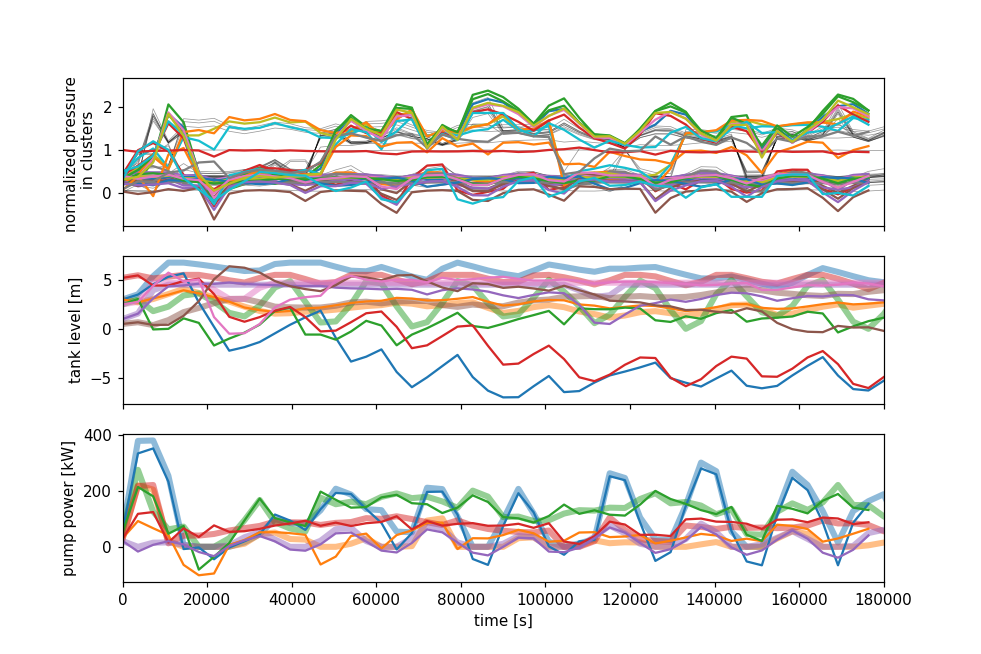

Text(0.5, 0, 'time [s]')

In [26]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,6))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')

# Linear Model

In [ ]:
linear_reg = LinearRegression().fit(nn_input_scaled.to_numpy(), nn_output_scaled.to_numpy())

In [ ]:
x0 = sys_states.head(1).to_numpy()
t0 = sys_states.head(1).index.to_numpy()

nsim_lin = simulator(linear_reg, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [ ]:
for k in range(10):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim_lin.next_step(sys_inputs_now)
sim_res_lin = pd.DataFrame(nsim_lin.x, columns=sys_states.columns, index=nsim_lin.t.flatten())
sim_aux_lin = pd.DataFrame(np.concatenate(nsim_lin.aux), columns = sys_aux_outputs.columns,index=nsim_lin.t.flatten()[:-1])

In [ ]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,9))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux_lin['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res_lin['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux_lin['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res_lin.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')